In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
cd /gdrive/MyDrive/4th Sem/Thesis/Hindi Hostility Detection/Final

/gdrive/.shortcut-targets-by-id/13B8T3YvpbNgM6K13VzUAYOijsibQvWUN/Thesis/Hindi Hostility Detection/Final


In [3]:
ls

Code/  Data/  Models/  Outputs/


#### Installing Required Libraries

In [4]:
!git clone https://github.com/uclnlp/emoji2vec "Data/Emoji Information" #for emoji2vec file

fatal: destination path 'Data/Emoji Information' already exists and is not an empty directory.


In [5]:
pip install fasttext -q

     |████████████████████████████████| 71kB 5.0MB/s 


In [6]:
pip install gensim -q

In [7]:
!pip install emoji -q

     |████████████████████████████████| 133kB 6.8MB/s 


In [8]:
!pip install emot -q

In [9]:
pip install ekphrasis -q

     |████████████████████████████████| 81kB 5.6MB/s 
     |████████████████████████████████| 184kB 43.6MB/s 
     |████████████████████████████████| 71kB 10.3MB/s 


In [10]:
pip install transformers -q

     |████████████████████████████████| 2.5MB 8.3MB/s 
     |████████████████████████████████| 3.3MB 50.6MB/s 
     |████████████████████████████████| 901kB 47.5MB/s 


In [11]:
pip install sentencepiece -q

     |████████████████████████████████| 1.2MB 7.9MB/s 


<h4> Importing Libraries

In [12]:
### General
import re
import copy
import string
import pickle
import numpy as np
import pandas as pd
import fasttext
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings

### Sklearn
import joblib
from sklearn import preprocessing
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score,f1_score
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

### Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

### Transformers
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup

### For Emojis and Hashtags
import emoji
from emot.emo_unicode import UNICODE_EMO, EMOTICONS
from ekphrasis.classes.segmenter import Segmenter


import gensim.models as gsm
import gensim
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors

In [13]:
MAX_LENGTH = 128

tokenizer   = AutoTokenizer.from_pretrained('monsoon-nlp/hindi-bert')
bert_model  = AutoModel.from_pretrained('monsoon-nlp/hindi-bert', output_hidden_states = True, output_attentions = True)


Some weights of the model checkpoint at monsoon-nlp/hindi-bert were not used when initializing ElectraModel: ['discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.weight']
- This IS expected if you are initializing ElectraModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [14]:
#Download the Hindi IndicFT word embeddings model from --> https://storage.googleapis.com/ai4bharat-public-indic-nlp-corpora/embedding-v2/indicnlp.ft.hi.300.bin
ft_model = fasttext.load_model('Models/IndicFT/indicnlp.ft.hi.300.bin')

In [15]:
seg_tw = Segmenter(corpus = "twitter")

Word statistics files not found!
Downloading... done!
Unpacking... done!
Reading twitter - 1grams ...
generating cache file for faster loading...
reading ngrams /root/.ekphrasis/stats/twitter/counts_1grams.txt
Reading twitter - 2grams ...
generating cache file for faster loading...
reading ngrams /root/.ekphrasis/stats/twitter/counts_2grams.txt


/usr/local/lib/python3.7/dist-packages/ekphrasis/classes/exmanager.py:14: FutureWarning: Possible nested set at position 42
  regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in


#### Configuration Class


In [16]:
class Config1:
    def __init__(self):
        super(Config1, self).__init__()

        self.SEED       = 42
        self.MODEL_PATH = 'Models/Pretrained/HindiBERT/checkpoint-2500'


        # data
        self.PERCENTAGE_DATA  = 100
        self.TOKENIZER        = AutoTokenizer.from_pretrained(self.MODEL_PATH)
        self.MAX_LENGTH       = 128
        self.BATCH_SIZE       = 16
        self.VALIDATION_SPLIT = 0.10
        self.PREPROCESS_INPUT = False

        # Coarse-grained or Fine-Grained
        self.NUM_LABELS           = 4                                        ### 1:CG   2:Combine    4:FG
        self.COARSE_GRAINED       = True if self.NUM_LABELS ==1 else False 
        self.COARSE_GRAINED_CLASS = 'Hostile'                                ### 'Fake' 'Defamation' 'Hate' or 'Offensive' 
        
        # Combining Hostile Dimensions
        self.COMBINE_HATE_OFFENSIVE  = False     #True if self.NUM_LABELS ==2 else False
        self.COMBINE_DEFAMATION_FAKE = False     #if self.NUM_LABELS ==2 else False


        ###Features to include
        self.SUPERVISED_LEXICON_ATTENTION = True
        self.HOSTILITY_LEXICON            = True
        self.LEXICON_AVERAGE              = False
        self.EMOJI_INFO                   = True
        self.EMBED_EMOJI                  = False    ### Doesnot do preprocessing, just adds emoji text into the post
        self.HASHTAG_INFO                 = True
        self.EMOJI_FLAG                   = " with Emoji"       ### "" or " without Emoji" or " with Emoji" --> space at beginning
        self.TOKENIZER_FLAG               = "Sentence Piece"
        self.PREPROCESSING_FLAG           = "Raw Text"
        
        ### Lexicon Parameters
        self.PAD_LENGTH = 128   ### Makes Sequence Length, Lexicon Vector, and gold attention vector 
        

        # model
        self.DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.NUMBER_OF_BERT_LAYERS = 1
        self.FULL_FINETUNING = True
        self.LR = 0.0001
        self.OPTIMIZER = 'AdamW'
        self.OUTPUT_HIDDEN_STATE=True
        self.OUTPUT_ATTENTIONS = True
        self.EPOCHS = 30

        ### Loss Hyperparameters
        self.DEFAMATION_LOSS_LAMBDA = 4.74
        self.FAKE_LOSS_LAMBDA       = 2.34
        self.HATE_LOSS_LAMBDA       = 3.38
        self.OFFENSIVE_LOSS_LAMBDA  = 3.64

        
        ### Load Checkpoint
        self.SAVE_BEST_ONLY   = True
        self.LOAD_CHECKPOINT  = False
        self.FINE_TUNE_COARSE = False
        self.CHECKPOINT_PATH  = ""
        self.MODEL_FOLDER     = "Models/HostileNet/"

        ### Visualization
        self.VISUALIZE_EMBEDDINGS = False
        self.PLOT_LOSS = True

        ### Evaluation 
        self.THRESHOLD = 0.5
        self.SERVER    = True

config = Config1()

warnings.filterwarnings("ignore")

<h3> Helper Functions

In [17]:
def masked_softmax(vec, mask, dim=0, epsilon=1e-5):
    exps = torch.exp(vec)
    masked_exps = exps * mask
    masked_sums = masked_exps.sum(dim, keepdim=True) + epsilon
    return (masked_exps/masked_sums)

In [18]:
def attention_mask(vec, mask, dim=1, epsilon=1e-5):
    masked = vec * mask
    masked_sums = masked.sum(dim, keepdim=True) + epsilon
    return (masked/masked_sums)

In [19]:
def weighted_avg(a, b):
    b = torch.unsqueeze(b,2)
    a = a.permute(0,2,1)
    c = torch.bmm(a,b)
    c = c.squeeze(2)
    return c

<h3>Dataset Class


In [20]:
class HindiHostilityDataset(Dataset):
    def __init__(self, dataset_path):
        super(HindiHostilityDataset, self).__init__()

        df          = pickle.load(open(dataset_path, 'rb'))
        
        if(config.COARSE_GRAINED == False and config.SERVER == True):
            df = df[df['Hostile']==1]
            df = df.reset_index(drop=True)       
        
        num_samples = int(config.PERCENTAGE_DATA*len(df)/100)
        df          = df.iloc[:num_samples,:] 
        
        print("Taking ",num_samples," only")
        if(config.PREPROCESS_INPUT):
            df = preprocess(df)

           
        self.texts             = get_texts(df)
        self.processed_texts   = get_processed_texts(df)
        self.tokenized_texts   = get_tokenized_texts(df)
        self.labels            = get_labels(df)
        self.gold_attn_vectors = get_gold_attention_vectors(df) ### Value at an index is a list four 50 dim vectors
        self.lexicon_vectors   = get_lexicons(df)               ### A vector of 50*4 size or 4 size vector
        self.lexicon_masks     = get_lexicon_masks(df)          ### A vector of size 128
        self.mha_masks         = get_mha_masks(df)
        self.emoji_vectors     = get_emoji_vectors(df)          ### A 300 dimension mean vector
        self.hashtag_vectors   = get_hashtag_vectors(df)        ### A 300 dimension mean vector

        self.max_length        = config.MAX_LENGTH
        self.tokenizer         = config.TOKENIZER
        

    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, index):

        tokenized_conts = self.tokenizer.encode_plus( self.texts[index], 
                                                      max_length=self.max_length,
                                                      padding='max_length',
                                                      truncation=True,
                                                      return_attention_mask=True,
                                                      return_token_type_ids=False,
                                                      return_tensors='pt')
        
        post_input_ids       = tokenized_conts['input_ids'].squeeze()
        post_attention_masks = tokenized_conts['attention_mask'].squeeze()

#         print(type(post_attention_masks))
#         print(type(post_attention_masks[0]))

        return { 'posts': {
                          'text': self.texts[index],
                          'processed_text'   : self.processed_texts[index],
                          'tokenized_text'   : self.tokenized_texts[index],
                          'lexicon_vector'   : torch.Tensor(self.lexicon_vectors[index]),
                          'gold_attn_vectors': torch.Tensor(self.gold_attn_vectors[index]),
                          'lexicon_mask'     : torch.Tensor(self.lexicon_masks[index]).type(torch.ByteTensor),
                          'mha_mask'         : torch.Tensor(self.mha_masks[index]).type(torch.ByteTensor),
                          'emoji_vector'     : torch.Tensor(self.emoji_vectors[index]),
                          'hashtag_vector'   : torch.Tensor(self.hashtag_vectors[index]),
                          'input_ids'        : post_input_ids,
                          'attention_masks'  : post_attention_masks
                        },
                
                 'labels': torch.Tensor(self.labels[index])#.float()
                }


In [21]:
### Hyper parameters: 

pad_length = 128

<h3> Data Preparation

In [27]:
def preprocess_text(text):
    org_text         = text
    text = emoji.demojize(text, delimiters=("" , " "))

    tokenized = tokenizer.encode_plus(text, 
                                      max_length = pad_length,
                                      padding    = 'max_length',
                                      truncation = True,
                                      return_attention_mask = True,
                                      return_token_type_ids = False,
                                      return_tensors        = 'pt')

    input_ids       = tokenized['input_ids']
    attention_masks = tokenized['attention_mask']


    text = tokenizer.convert_ids_to_tokens(input_ids[0])
    text = ' '.join(text)

    print("Input IDs Shape:       ",input_ids.shape)
    print("Attention Mask Shape:  ",attention_masks.shape)


    average_lexicon = [0.,0.,0.,0.,0.]
    lexicon_vector  = []
    lexicon_mask    = []
    hostility_dict  = pickle.load(open("Data/Multi-Label Lexicon/Hostility Dict Raw Text with Emoji.pkl", 'rb'))

    text = text.split()
    for word in text:
        if(hostility_dict.get(word)!=None):
            if(sum(hostility_dict[word])!=0):
    #             print("Accepted: ",word)
                lexicon_mask.append(1)
                lexicon_vector.append(hostility_dict[word])
                average_lexicon = [i+j for i,j in zip(average_lexicon, hostility_dict[word])]
            else:
    #             print("Rejected: ",word)
                lexicon_vector.append([0.]*5)
                lexicon_mask.append(0)

        else:
    #         print("Rejected: ",word)
            lexicon_vector.append([0.]*5)
            lexicon_mask.append(0)


    length = int(torch.sum(attention_masks))
    average_lexicon = [i/length for i in average_lexicon]


    def_gold_attn    = []
    fake_gold_attn   = []
    hate_gold_attn   = []
    off_gold_attn    = []
    gold_attn_vector = []

    for j in lexicon_vector:
        def_gold_attn.append(j[0])
        fake_gold_attn.append(j[1])
        hate_gold_attn.append(j[2])
        off_gold_attn.append(j[3])  


    def_gold_attn  = masked_softmax(torch.tensor(def_gold_attn), torch.tensor(lexicon_mask))
    fake_gold_attn = masked_softmax(torch.tensor(fake_gold_attn), torch.tensor(lexicon_mask))
    hate_gold_attn = masked_softmax(torch.tensor(hate_gold_attn), torch.tensor(lexicon_mask))
    off_gold_attn  = masked_softmax(torch.tensor(off_gold_attn), torch.tensor(lexicon_mask))

    gold_attn_vector.append(np.asarray(def_gold_attn))
    gold_attn_vector.append(np.asarray(fake_gold_attn))
    gold_attn_vector.append(np.asarray(hate_gold_attn))
    gold_attn_vector.append(np.asarray(off_gold_attn))

    gold_attn_vector = torch.Tensor(gold_attn_vector)
    

    lexicon_vector  = torch.Tensor(np.asarray(lexicon_vector))
    average_lexicon = torch.Tensor(np.asarray(average_lexicon))
    lexicon_mask    = torch.Tensor(np.asarray(lexicon_mask)).type(torch.ByteTensor)
    mha_mask        = 1 - lexicon_mask

    print("Lexicon Vector Shape:  ", lexicon_vector.shape)
    print("Lexicon Vec Avg Shape: ", average_lexicon.shape)
    print("Lexicon Mask Shape:    ", lexicon_mask.shape)
    print("MHA Mask Shape:        ", mha_mask.shape)

    print("Gold Attn Shape:       ", gold_attn_vector.shape)



    avg_hashtag_vectors = []
    sum_hashtag_vectors = []

    hashtag_text = org_text

    hashtag_text = ' '.join([seg_tw.segment(word[1:]) if word[0] == '#' else "" for word in hashtag_text.split()])

    hashtag_text = hashtag_text.split()

    if(len(hashtag_text)==0):          
        avg_hashtag_vector = ft_model['#']
        sum_hashtag_vector = ft_model['#']

    else:
        sum_hashtag_vector = np.zeros(300)

        for hashtag in hashtag_text:
            sum_hashtag_vector += ft_model[hashtag]

        avg_hashtag_vector = [i/len(hashtag_text) for i in sum_hashtag_vector]

    avg_hashtag_vector = torch.Tensor(avg_hashtag_vector)
    sum_hashtag_vector = torch.Tensor(sum_hashtag_vector)


    print("Avg Hashtag Shape:     ",avg_hashtag_vector.shape)
    print("Sum Hashtag Shape:     ",sum_hashtag_vector.shape)


    ### For Emojis
    emoji_text   = org_text 

    avg_emoji_vectors = []
    sum_emoji_vectors = []

    emoji_text = ''.join(emo for emo in emoji_text if emo in UNICODE_EMO)
    avg_emoji_vector = np.zeros(300)
    sum_emoji_vector = np.zeros(300)

    if(len(emoji_text)!=0):
        for emo in emoji_text:
            try:
                sum_emoji_vector += e2v[emo]
            except:
                sum_emoji_vector += np.zeros(300)
        avg_emoji_vector = sum_emoji_vector/len(emoji_text)

    avg_emoji_vector = torch.Tensor(avg_emoji_vector)
    sum_emoji_vector = torch.Tensor(sum_emoji_vector)

    print("Avg Emoji Shape:       ",avg_emoji_vector.shape)
    print("Sum Emoji Shape:       ",sum_emoji_vector.shape)
    
    tokenized_text = ' '.join(text)

    return tokenized_text,input_ids, attention_masks, lexicon_vector, average_lexicon, lexicon_mask, mha_mask,\
           gold_attn_vector, avg_hashtag_vector, sum_hashtag_vector, avg_emoji_vector, sum_emoji_vector


<h3> Model

In [23]:
class BaseModel2(nn.Module):
    def __init__(self):
        super(BaseModel2, self).__init__()
    
    
        self.bert_model          = AutoModel.from_pretrained(config.MODEL_PATH, output_hidden_states = config.OUTPUT_HIDDEN_STATE, output_attentions = config.OUTPUT_ATTENTIONS)
        self.dropout             = nn.Dropout(0.25)
              
        self.complete_mha = nn.MultiheadAttention(embed_dim = 128, num_heads=4)

        self.lstm_lexicon                  = nn.LSTM(input_size = 4, hidden_size = 32, batch_first=True, bidirectional=True )

        ## Gave poor results with Lex Encoder
        ##self.lex_encoder_layer     = nn.TransformerEncoderLayer(d_model=4, nhead=4, dropout=0.25)
        ##self.lex_encoder           = nn.TransformerEncoder(self.lex_encoder_layer, num_layers=6) ### Seq, Batch, Embedding

        self.linear_lexicon                = nn.Linear(64, 32)
        self.linear_emoji                  = nn.Linear(300, 32)
        self.linear_hashtag                = nn.Linear(300, 32)

        self.concat_fc1                    = nn.Linear(864, 128)
        self.concat_fc2                    = nn.Linear(128, config.NUM_LABELS)



    def forward(self, input_ids, attention_masks, gold_attn_vectors=None, lexicon_vector=None,lexicon_masks =None, mha_masks=None, emoji_vector=None, hashtag_vector=None):
        
        output_embeddings, hidden_states, attention = self.bert_model(input_ids = input_ids, attention_mask = attention_masks).values()

        bert_attn = attention[-1]                      ### [16,4,128,128]
        
        d_bert_attn = bert_attn[:,0,:config.PAD_LENGTH,:config.PAD_LENGTH]
        f_bert_attn = bert_attn[:,1,:config.PAD_LENGTH,:config.PAD_LENGTH]
        h_bert_attn = bert_attn[:,2,:config.PAD_LENGTH,:config.PAD_LENGTH]
        o_bert_attn = bert_attn[:,3,:config.PAD_LENGTH,:config.PAD_LENGTH]

        d_bert_attn = torch.mean(d_bert_attn, 1)      ### [16,128]
        f_bert_attn = torch.mean(f_bert_attn, 1)      ### [16,128]
        h_bert_attn = torch.mean(h_bert_attn, 1)      ### [16,128]
        o_bert_attn = torch.mean(o_bert_attn, 1)      ### [16,128]
        
        d_bert_attn = attention_mask(d_bert_attn, lexicon_masks)
        f_bert_attn = attention_mask(f_bert_attn, lexicon_masks)
        h_bert_attn = attention_mask(h_bert_attn, lexicon_masks)
        o_bert_attn = attention_mask(o_bert_attn, lexicon_masks)


        ### original Input     --> N S E --> 16 128 768
        ### Transformer Input  --> S N E --> 128 16 768
        ### Transformer Output --> S N E --> 128 16 768
        
        
        concat_attn       = torch.cat((d_bert_attn, f_bert_attn, h_bert_attn, o_bert_attn),0)
        concat_attn       = concat_attn.reshape(4, len(input_ids), config.PAD_LENGTH)
        concat_attn       = self.complete_mha(concat_attn, concat_attn, concat_attn)
        concat_attn       = concat_attn[0].permute(1,0,2)
        concat_attn       = torch.flatten(concat_attn, start_dim=1)                ### [16,512]

        ### Main Stem --> Augmenting Lexicon Vector + Emoji Vector

        output_embeddings = torch.mean(output_embeddings, 1)
        
        lexicon_vector = lexicon_vector[:, :, :-1]
        lexicon_all_hidden_states, (lexicon_last_hidden_state, lexicon_cell_state) = self.lstm_lexicon(lexicon_vector) # [16, 128, 64]
        lexicon_sum_hidden_states = torch.sum(lexicon_all_hidden_states, 1)  ### [16,64]
        lexicon_drop = self.dropout(lexicon_sum_hidden_states)               ### [16,64]
        lexicon_linear = self.linear_lexicon(lexicon_drop)                   ### [16,32]

        emoji_vector      = self.linear_emoji(emoji_vector)                  ### [16,32]  (300 --> 32)
        hashtag_vector    = self.linear_hashtag(hashtag_vector)              ### [16,32]  (300 --> 32)

        features           = torch.cat((lexicon_linear, emoji_vector,hashtag_vector),dim=1)  ### [16,96]
        features_drop      = self.dropout(features)        

        concat            = torch.cat((output_embeddings,concat_attn, features_drop),dim=1) ### [main_stem, d_out,  f_out,  h_out,  o_out]
        model_outputs     = self.concat_fc1(concat)
        model_outputs     = self.concat_fc2(model_outputs)

        
        
        ### Supervised Attention Loss
        model_attentions    = [[gold_attn_vectors[:,0,:], d_bert_attn],
                               [gold_attn_vectors[:,1,:], f_bert_attn],
                               [gold_attn_vectors[:,2,:], h_bert_attn],
                               [gold_attn_vectors[:,3,:], o_bert_attn]]


        return model_outputs, model_attentions

In [83]:
model = BaseModel2()
# model.to(config.DEVICE)

checkpoint_path  = "Models/HostileNet/Fine-Grained Final/HostileNet (BCE + KL) F1 - 0.6632663603397878 Epoch 17.pt"
# checkpoint_path  = "Models/HostileNet/Fine-Grained Final/HostileNet (BCE + ASL) F1 - 0.6475900694781694 Epoch 7.pt"
# checkpoint_path = "Models/HostileNet/Fine-Grained Final/HostileNet (BCE + MSE) F1 - 0.6463065255964119 Epoch 5.pt"
# checkpoint_path = "Models/HostileNet/Fine-Grained Final/HostileNet with no attn tuning F1 - 0.6431428216177454 Epoch 8.pt"


model_index = 0
model_names = ['HostileNet with KL Divergence Loss', 
               'HostileNet with Asymmetric Loss',
               'HostileNet with MSE Loss',
               'HostileNet without Supervised Attention']

model_name = model_names[model_index]


checkpoint      = torch.load(checkpoint_path)

Some weights of the model checkpoint at Models/Pretrained/HindiBERT/checkpoint-2500 were not used when initializing ElectraModel: ['generator_predictions.LayerNorm.weight', 'generator_lm_head.bias', 'generator_lm_head.weight', 'generator_predictions.dense.weight', 'generator_predictions.dense.bias', 'generator_predictions.LayerNorm.bias']
- This IS expected if you are initializing ElectraModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [84]:
print("\n\n------------------- Loading Checkpoint-----------------------\n\n")
warnings.filterwarnings("ignore")
model.load_state_dict(checkpoint['state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer'])
# scheduler.load_state_dict(checkpoint['scheduler'])
max_val_f1_score = checkpoint['val_f1_score']
warnings.filterwarnings("default")



------------------- Loading Checkpoint-----------------------




In [85]:
### Defamation + Fake
text = "अभिनंदन ने बीजेपी पर आरोप लगाते हुए बयान दिया है कि पुलवामा हमला बीजेपी की सोची समझी साजिश थी #FactCheck (@Ami_Amanpreet)"

### Hate and Offensive
# text = "@TRHLofficial ट्रम्प हमारे लोकतंत्र के लिए खतरा हैं! इसके अलावा, अगर मेरा पक्ष किसी एक मुद्दे पर हार जाता है, तो मैं इस कुतिया को बंद करने की योजना बनाता हूं! दंगों! गृह युद्ध!"

### Non Hostile
# text = "कफ़ील खान के मामले में हाई कोर्ट का फ़ैसला योगी सरकार के अन्यायी चेहरे को बेनक़ाब करता है ध्यान से पढ़ो योगी जी, हाई कोर्ट ने कहा “कफ़ील खान का भाषण राष्ट्रीय एकता और अखंडता की अपील करता है” और योगी जी ने कफ़ील को राष्ट्रद्रोही घोषित कर दिया “शर्मनाक” #drkafeelkhan https://t.co/nB9Jhlvm93"

tokenized_text, input_ids, attention_masks, lexicon_vector, average_lexicon,\
lexicon_mask, mha_mask, gold_attn_vector, avg_hashtag_vector, \
sum_hashtag_vector, avg_emoji_vector, sum_emoji_vector = preprocess_text(text)

Input IDs Shape:        torch.Size([1, 128])
Attention Mask Shape:   torch.Size([1, 128])
Lexicon Vector Shape:   torch.Size([128, 5])
Lexicon Vec Avg Shape:  torch.Size([5])
Lexicon Mask Shape:     torch.Size([128])
MHA Mask Shape:         torch.Size([128])
Gold Attn Shape:        torch.Size([4, 128])
Avg Hashtag Shape:      torch.Size([300])
Sum Hashtag Shape:      torch.Size([300])
Avg Emoji Shape:        torch.Size([300])
Sum Emoji Shape:        torch.Size([300])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: ResourceWarning: unclosed file <_io.BufferedReader name='Data/Multi-Label Lexicon/Hostility Dict Raw Text with Emoji.pkl'>


In [86]:
### preparing some data as a batch
# input_ids          = torch.unsqueeze(input_ids,0)
# attention_masks    = torch.unsqueeze(attention_masks, 0)

lexicon_vector     = torch.unsqueeze(lexicon_vector,0)
lexicon_mask       = torch.unsqueeze(lexicon_mask, 0)
gold_attn_vector   = torch.unsqueeze(gold_attn_vector,0)

avg_emoji_vector   = torch.unsqueeze(avg_emoji_vector, 0)
avg_hashtag_vector = torch.unsqueeze(avg_hashtag_vector, 0)

print(lexicon_vector.shape)

torch.Size([1, 128, 5])


In [87]:
outputs, attentions = model(input_ids, attention_masks, gold_attn_vector, lexicon_vector, lexicon_mask, mha_mask, avg_emoji_vector, avg_hashtag_vector)

In [88]:
outputs = torch.sigmoid(outputs.detach())
outputs = np.round(outputs.numpy())
outputs

array([[1., 1., 0., 0.]], dtype=float32)

In [89]:
torch.sum(attentions[0][1][0])

tensor(1.0000, grad_fn=<SumBackward0>)

In [90]:
print(tokenized_text)

[CLS] अभिन ##ंदन ने बीजेपी पर आरोप लगाते हुए बयान दिया है कि पुल ##वा ##मा हमला बीजेपी की सोची समझी साजिश थी # F ##act ##C ##he ##ck ( @ Am ##i _ Am ##an ##pr ##ee ##t ) [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


In [91]:
temp_text = tokenized_text
temp_attention = attentions[0][0]

In [92]:
def merge_attention(text, text_attention):

    new_text = []
    new_attention = []
    text = text.split()
    ### ord("m") is used to get the ascii value; tokenized _ has ord 9601 where are normal _ has 95
    
    
    flag  = 0
    count = 0
    
    for word,attention in zip(text, text_attention[0]):
#         print(word)
        if((len(new_text) == 0)) :
#             print("CASE 1: ",word)
            new_text.append(word)
            new_attention.append(attention)
            flag = 1
            count = 1
    
        elif( (len(new_text)>1 and (new_text[-1] == '#'))):
#             print("CASE 3: ",word)
            new_text[-1] += word
            new_attention[-1] += attention
            count += 1
    

     
        elif( (len(word) == 1)  or ((ord(word[0]) != 35) and (ord(word[1]) != 35)) ):
            
#             print("Dump: ",word)
            new_attention[-1] = new_attention[-1]/count
            new_text.append(word)
            new_attention.append(attention)
            flag = 1
            count = 1

            
            
        elif( (((ord(word[0]) == 35) and (ord(word[1]) == 35)) and (flag==1)) \
              or ( (ord(word[0]) == 35) and (flag==1))):
            
#             print("CASE 2: ",word)
            if(len(word)>2):
                new_text[-1] += word[2:]
            else:
                new_text[1] += word[1]
            new_attention[-1] += attention
            count += 1
        
        else:
#             print("BC: ",word)
            new_attention[-1] = new_attention[-1]/count
            new_text.append(word)
            new_attention.append(attention)
            flag = 0
            count = 0

    return new_text, new_attention

In [93]:
for i in range(4):
    for j in range(2):
        text, attentions[i][j] = merge_attention(tokenized_text, np.asarray(attentions[i][j].detach()))



In [94]:
def merge_emoji_text(text, text_attention):
    

    ### For attaching underscores --> folded _ hands --> folded_hands
    new_text = []
    new_attention = []
    flag = 0
    
    for word,attention in zip(text, text_attention):
        
        if(ord(word[0]) != 95 and flag==0):
            new_text.append(word)
            new_attention.append(attention)
        elif(ord(word[0]) == 95 and flag==0):
            new_text[-1]      += word
            new_attention[-1] += attention
            flag = 1
        else:
            new_text[-1]      += word
            new_attention[-1] += attention
            flag = 0
            
    ### For attaching @ user ---> @user
    new_text_2 = []
    new_attention_2 = []
    flag = 0 
    for word,attention in zip(new_text, new_attention):
        
        if(ord(word[0]) != 64 and flag==0):
            new_text_2.append(word)
            new_attention_2.append(attention)
            
        elif(ord(word[0]) == 64 and flag==0):
            new_text_2.append(word)
            new_attention_2.append(attention)
            flag = 1
            
        else:
            new_text_2[-1]      += word
            new_attention_2[-1] += attention
            flag = 0
    
    new_text = new_text_2
    new_attention = new_attention_2
            
        
    new_text = ''.join([emoji.emojize(':'+word+':') if( emoji.emojize(':'+word+':') in UNICODE_EMO) else ' '+word+' ' for word in new_text])
    new_text = emoji.emojize(new_text).split()
    new_text = ' '.join(new_text)
    new_text = new_text.replace("[PAD]", '')
    new_text = new_text.split()      
    new_attention = new_attention[:len(new_text)]
    
    return new_text, new_attention

In [95]:
for i in range(4):
    for j in range(2):
        temp_text = text
        temp_attention = attentions[i][j]
        new_text, attentions[i][j] = merge_emoji_text(temp_text, np.asarray(temp_attention))



In [96]:
for i,scores in enumerate(zip(new_text,attentions[0][1])):
    print(f'{i:3} --> {scores[0]:7} --> {float(scores[1]):10.5}' )

  0 --> [CLS]   -->        0.0
  1 --> अभिनंदन -->   0.017148
  2 --> ने      -->   0.017631
  3 --> बीजेपी  -->   0.050543
  4 --> पर      -->   0.018304
  5 --> आरोप    -->   0.050096
  6 --> लगाते   -->   0.018167
  7 --> हुए     -->   0.017591
  8 --> बयान    -->   0.017117
  9 --> दिया    -->   0.018019
 10 --> है      -->   0.023201
 11 --> कि      -->   0.017385
 12 --> पुलवामा -->   0.028253
 13 --> हमला    -->    0.01713
 14 --> बीजेपी  -->   0.050963
 15 --> की      -->   0.019704
 16 --> सोची    -->   0.050392
 17 --> समझी    -->    0.05105
 18 --> साजिश   -->   0.024952
 19 --> थी      -->   0.027163
 20 --> #FactCheck -->   0.025551
 21 --> (       -->   0.016779
 22 --> @Ami_Amanpreet -->    0.10637
 23 --> )       -->   0.016885
 24 --> [SEP]   -->        0.0


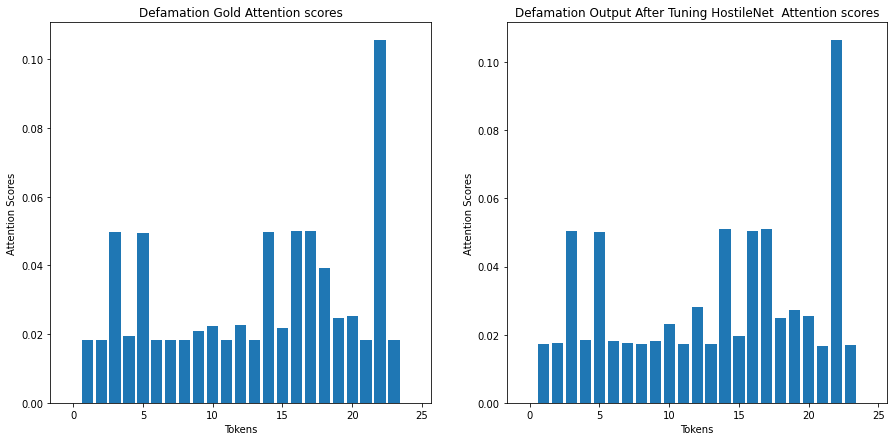

In [97]:
dim_ind  = 0
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,7))

counter = 0
x       = np.arange(0, len(attentions[dim_ind][0]))
attn    = [attentions[dim_ind][0], attentions[dim_ind][1]]
word    = ["Gold", "Output After Tuning HostileNet "]
hostile = ["Defamation ", "Fake ", "Hate ", "Offensive "]

for col in ax:
    scores = attn[counter]
    col.bar(x, scores)
    col.set_xlabel("Tokens")
    col.set_ylabel("Attention Scores")
    title = hostile[dim_ind] + word[counter] + " Attention scores"
    col.set_title(title)
    counter += 1
plt.show()

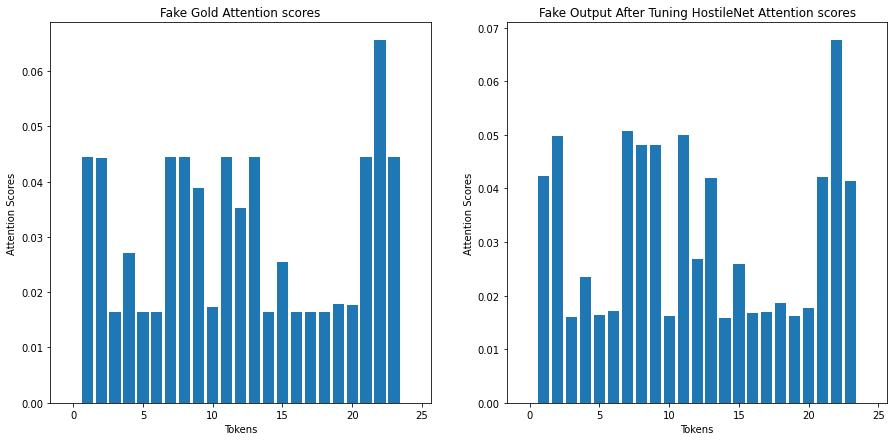

In [98]:
dim_ind  = 1
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,7))

counter = 0
x       = np.arange(0, len(attentions[dim_ind][0]))
attn    = [attentions[dim_ind][0], attentions[dim_ind][1]]
word    = ["Gold", "Output After Tuning HostileNet"]
hostile = ["Defamation ", "Fake ", "Hate ", "Offensive "]

for col in ax:
    scores = attn[counter]
    col.bar(x, scores)
    col.set_xlabel("Tokens")
    col.set_ylabel("Attention Scores")
    title = hostile[dim_ind] + word[counter] + " Attention scores"
    col.set_title(title)
    counter += 1
plt.show()

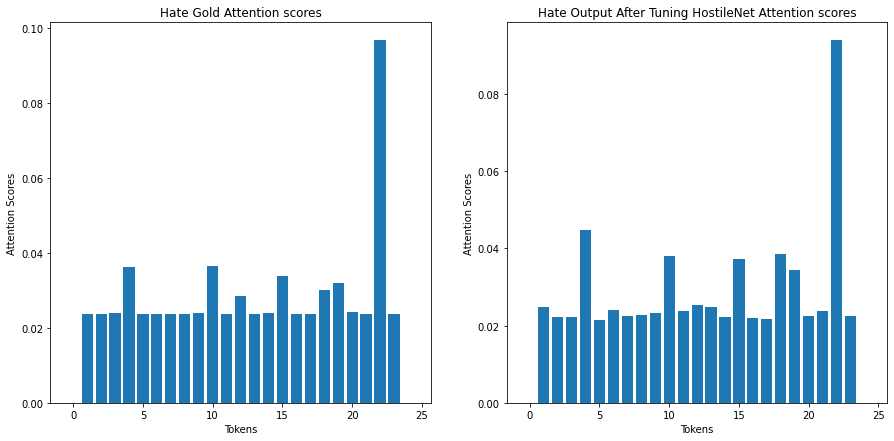

In [99]:
dim_ind  = 2
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,7))

counter = 0
x       = np.arange(0, len(attentions[dim_ind][0]))
attn    = [attentions[dim_ind][0], attentions[dim_ind][1]]
word    = ["Gold", "Output After Tuning HostileNet"]
hostile = ["Defamation ", "Fake ", "Hate ", "Offensive "]

for col in ax:
    scores = attn[counter]
    col.bar(x, scores)
    col.set_xlabel("Tokens")
    col.set_ylabel("Attention Scores")
    title = hostile[dim_ind] + word[counter] + " Attention scores"
    col.set_title(title)
    counter += 1
plt.show()

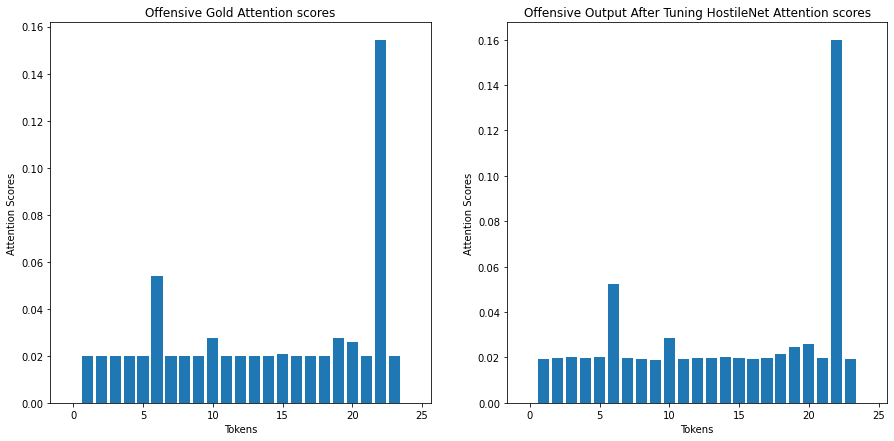

In [100]:
dim_ind  = 3
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,7))

counter = 0
x       = np.arange(0, len(attentions[dim_ind][0]))
attn    = [attentions[dim_ind][0], attentions[dim_ind][1]]
word    = ["Gold", "Output After Tuning HostileNet"]
hostile = ["Defamation ", "Fake ", "Hate ", "Offensive "]

for col in ax:
    scores = attn[counter]
    col.bar(x, scores)
    col.set_xlabel("Tokens")
    col.set_ylabel("Attention Scores")
    title = hostile[dim_ind] + word[counter] + " Attention scores"
    col.set_title(title)
    counter += 1
plt.show()

<h4> Generating Latex Attention Output

In [101]:
def get_label(label):
    label_vector = ""

    if(label[0]==1.0):
        label_vector += "defamation,"

    if(label[1]==1.0):
        label_vector += "fake,"

    if(label[2]==1.0):
        label_vector += "hate,"

    if(label[3]==1.0):
        label_vector += "offensive,"

    if(label_vector ==""):
        label_vector = "non-hostile "

    label_vector = label_vector[:-1]
    return label_vector

In [103]:
### Reference from: https://github.com/jiesutd/Text-Attention-Heatmap-Visualization/blob/master/text_attention.py

## convert the text/attention list to latex code, which will further generates the text heatmap based on attention weights.
import numpy as np

latex_special_token = ["!@#$%^&*()"]

def generate(text_list, attention_list, latex_file, flag, dim_ind, model_name, color='red', rescale_value = False):
    assert(len(text_list) == len(attention_list))
    if rescale_value:
        attention_list = rescale(attention_list)
    word_num = len(text_list)
    text_list = clean_word(text_list)
    
    if(flag==0):
        with open(latex_file,'w') as f:
            f.write(r'''
            
\documentclass{report}
\usepackage{polyglossia}

\setdefaultlanguage{hindi}
\setotherlanguage{english}

\usepackage{fontspec}
\setmainfont{Times New Roman}
\newfontfamily\devanagarifont[Scale=MatchUppercase]{Nakula}
\newfontfamily\devtransl[Mapping=DevRom]{Times New Roman}
\setmainfont{Nakula}

\special{papersize=210mm,297mm}
\usepackage{color}
\usepackage{tcolorbox}
\usepackage{CJK}
\usepackage{adjustbox}


\tcbset{width=0.9\textwidth,boxrule=0pt,colback=red,arc=0pt,auto outer arc,left=0pt,right=0pt,boxsep=5pt}


\begin{document}''' +'\n')
            
            if(dim_ind==0):
                f.write(r'''\noindent Gold Defamation Attention Scores Heatmap\\''' + '\n')

            elif(dim_ind==1):
                f.write(r'''\noindent Gold Fake Attention Scores Heatmap\\''' + '\n')

            elif(dim_ind==2):
                f.write(r'''\noindent Gold Hate Attention Scores Heatmap\\''' + '\n')
            else:
                f.write(r'''\noindent Gold Offensive Attention Scores Heatmap\\''' + '\n')

            f.write(r'''\begin{CJK*}{UTF8}{gbsn}'''+'\n')

            string = r'''{\setlength{\fboxsep}{0pt}\colorbox{white!0}{\parbox{0.9\textwidth}{'''+"\n"
            for idx in range(word_num):
                string += "\\colorbox{%s!%s}{"%(color, attention_list[idx])+"\\strut " + text_list[idx]+"} "
            string += "\n}}}"
            f.write(string+'\n')
            f.write(r'''\end{CJK*}''')
            
    if(flag==1):
         with open(latex_file,'a') as f:
            f.write(r'''\break \\ \\''' + '\n')

            if(dim_ind==0):
                f.write(r'''\noindent ''' + model_name + ''' - Defamation Attention Scores Heatmap''' + '\n')

            elif(dim_ind==1):
                f.write(r'''\noindent ''' + model_name + ''' - Fake Attention Scores Heatmap''' + '\n')

            elif(dim_ind==2):
                f.write(r'''\noindent ''' + model_name + ''' - Hate Attention Scores Heatmap''' + '\n')
            else:
                f.write(r'''\noindent ''' + model_name + ''' - Offensive Attention Scores Heatmap''' + '\n')
            
            f.write(r'''\noindent \\ \begin{CJK*}{UTF8}{gbsn}'''+'\n')

            string = r'''{\setlength{\fboxsep}{0pt}\colorbox{white!0}{\parbox{0.9\textwidth}{'''+"\n"
            for idx in range(word_num):
                string += "\\colorbox{%s!%s}{"%(color, attention_list[idx])+"\\strut " + text_list[idx]+"} "
            string += "\n}}}"
            f.write(string+'\n')
            f.write(r'''
\end{CJK*}
\end{document}''')
            

def rescale(input_list):
    the_array = np.asarray(input_list)
    the_max = np.max(the_array)
    the_min = np.min(the_array)
    rescale = (the_array - the_min)/(the_max-the_min)*100
    return rescale.tolist()


def clean_word(word_list):
    new_word_list = []
    for word in word_list:
        for latex_sensitive in [ '\\', "%", "&", "^", "_",  "{", "}", "#"]:
            if latex_sensitive in word:
                word = word.replace(latex_sensitive, '\\'+latex_sensitive)
        new_word_list.append(word)
    return new_word_list



# colors  = ['red', 'cyan', 'lime', 'orange']
colors  = ['orange', 'lime', 'red', 'cyan']



indexes = [0,1,2,3]
words = new_text
words = words[1:-1]
word_num = len(words)
label = get_label(outputs[0])

print(label,"\n\n")
file_names = ["Outputs/" + label+" Defamation.tex", 
              "Outputs/" + label+" Fake.tex",
              "Outputs/" + label+" Hate.tex",
              "Outputs/" + label+" Offensive.tex"]

top_five = [0,0,0,0]
for dim_ind in indexes:
    for flag in range(2):
        if(flag==0):
            if(dim_ind==0):
                print("Gold Defamation Attention Scores: \n")
            
            elif(dim_ind==1):
                print("Gold Fake Attention Scores: \n")
            
            elif(dim_ind==2):
                print("Gold Hate Attention Scores: \n")
            
            else:
                print("Gold Offensive Attention Scores: \n")
        else:
            if(dim_ind==0):
                print(model_names[model_index]+"Defamation Attention Scores: \n")
            
            elif(dim_ind==1):
                print(model_names[model_index]+"Fake Attention Scores: \n")
            
            elif(dim_ind==2):
                print(model_names[model_index]+"Hate Attention Scores: \n")
            
            else:
                print(model_names[model_index]+"Offensive Attention Scores: \n")
                        
        attention = attentions[dim_ind][flag]
        attention = attention[1:-1]
        attention = [100*i for i in attention]
        attention = np.asarray(attention)
        attention = np.where(np.argsort(np.argsort(attention)) >= attention.shape[0]-10, attention, 0)

        flag_low = 1
        for attn in attention:
            if(attn>28):
                flag_low=0
                break

        if flag_low == 1:
            print("Hello")
            for i in range(len(attention)):
                attention[i] = 5*attention[i]


        for i in range(len(attention)):
            if(attention[i]>100):
                attention[i] = 99.99

            if(attention[i]>0):
                print(words[i], attention[i])





    
        print("\n\n")
        color = colors[dim_ind]
        file_name = file_names[dim_ind]
        generate(words, attention[:len(words)], file_name, flag, dim_ind, model_name, color)

defamation,fake 


Gold Defamation Attention Scores: 

Hello
बीजेपी 24.843065068125725
आरोप 24.775506928563118
पुलवामा 11.361099779605865
बीजेपी 24.843065068125725
सोची 24.96565505862236
समझी 24.965718388557434
साजिश 19.646435976028442
थी 12.302948161959648
#FactCheck 12.696228921413422
@Ami_Amanpreet 52.739742398262024



HostileNet with KL Divergence LossDefamation Attention Scores: 

Hello
बीजेपी 25.27131512761116
आरोप 25.048136711120605
पुलवामा 14.126678307851158
बीजेपी 25.481289252638817
सोची 25.196151807904243
समझी 25.524897500872612
साजिश 12.476165778934956
थी 13.581531122326851
#FactCheck 12.77561609943708
@Ami_Amanpreet 53.18521838635206



Gold Fake Attention Scores: 

Hello
अभिनंदन 22.257033735513687
ने 22.14287780225277
हुए 22.256886586546898
बयान 22.23125472664833
दिया 19.376516342163086
कि 22.226734086871147
हमला 22.256163880228996
( 22.257033735513687
@Ami_Amanpreet 32.76390992105007
) 22.257033735513687



HostileNet with KL Divergence LossFake Attention Scores: 

Hello